In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits
from data_process import calculate_jackknife_variance, load_calculation_data, calculate_jackknife_variance_global

In [3]:
lmax = 2048

In [3]:
fwhm = 6

In [4]:
r_p, dat = load_calculation_data(f'../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_smoothed_{fwhm}_tree.npy', return_rp=True)
dat_r = load_calculation_data(f'../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_{fwhm}_tree.npy')

value = dat[0]
weight = dat[1]
value_r = dat_r[0]
weight_r = dat_r[1]

with open('label.bin', 'rb') as f:
    pix = np.load(f)
    pix_r = np.load(f)


In [ ]:
# Nside_jack = 10
# quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
# c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)

# l = c.galactic.l.to(u.rad).value
# b = c.galactic.b.to(u.rad).value
# pix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

# print('finish loading quasar catalogue')

# random_sample = np.load('../catalogue/random_quasar_lss_all.npy')
# c = coo.SkyCoord(ra=random_sample['ra']*u.degree, dec=random_sample['dec']*u.degree)

# l = c.galactic.l.to(u.rad).value
# b = c.galactic.b.to(u.rad).value
# pix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

# print('finish loading random sample')

In [11]:
savefig = False

## quasar sample

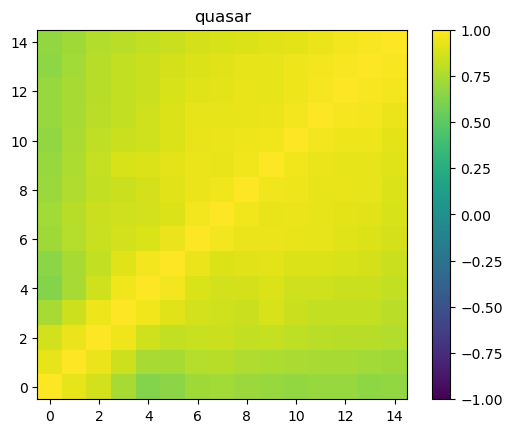

In [33]:
sampler_q = calculate_jackknife_variance_global(value, weight, pix, norm_cov=True)
plt.imshow(sampler_q['cov'], origin='lower', vmin=-1, vmax=1)
plt.colorbar()
plt.title('quasar')
if savefig:
    plt.savefig('./fig/cov_q')
plt.show()

## random sample

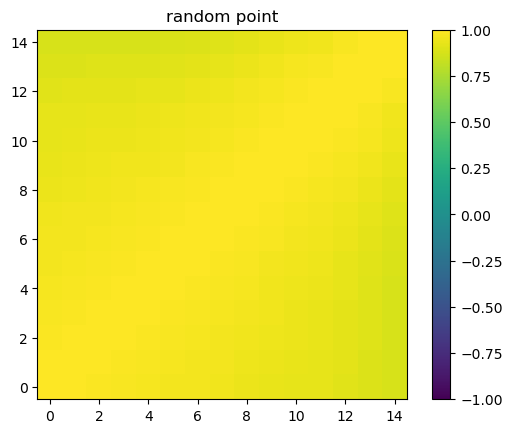

In [34]:
sampler_r = calculate_jackknife_variance_global(value_r, weight_r, pix_r, norm_cov=True)
plt.imshow(sampler_r['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('random point')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_r')
plt.show()

## quasar - random

NameError: name 'savefig' is not defined

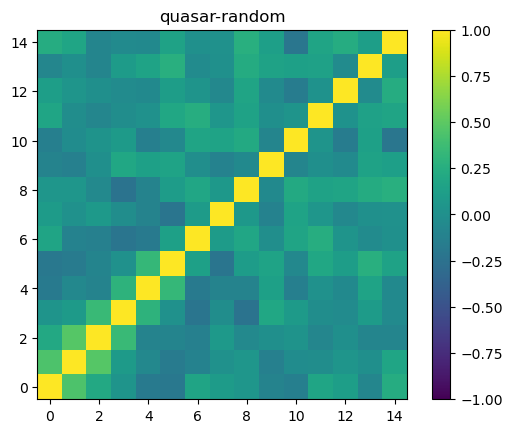

In [6]:
sampler_sub = calculate_jackknife_variance_global(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True, return_jackknife=True)
plt.imshow(sampler_sub['cov'], origin='lower', vmin=-1, vmax=1)
plt.title('quasar-random')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_qr')
plt.show()

In [23]:
np.savetxt(f'./results/quasar_lss_all_cmb_smoothed_{fwhm}', np.c_[r_p, sampler_sub['mean'], sampler_sub['std']])

In [7]:
np.save('cross_corr_jackknife_kmeans_100_new', sampler_sub['jackknife'])

## signal

In [21]:
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100

In [29]:
(200/2048)*60

5.859375

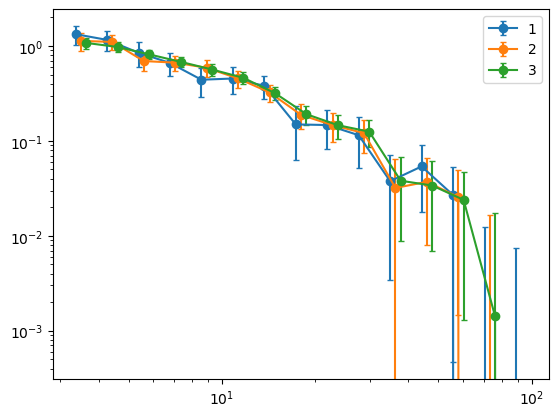

In [44]:
res = np.loadtxt('./results/quasar_lss_all_cmb_lcut_2048')
res_2 = np.loadtxt('./results/quasar_lss_all_cmb_smoothed_6')
res_3 = np.loadtxt('./results/quasar_lss_all_cmb_smoothed_8')

r_p = res[:,0]
plt.errorbar(r_p, res[:,1], res[:,2], capsize=2, fmt='-o', label='1')
plt.errorbar(r_p*1.04, res_2[:,1], res_2[:,2], capsize=2, fmt='-o', label='2')
plt.errorbar(r_p*1.04, res_3[:,1], res_3[:,2], capsize=2, fmt='-o', label='3')
plt.loglog()
plt.legend()